# Transatlantic alcohol preferences

In the following, we will try to answer the following question: **do Americans prefer beers with high alcohol content compared to Europeans?**

## Preparations

### Importing modules

In [1]:
# Python modules
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy
import numpy as np
import statsmodels.api as sm
from tqdm import tqdm
from matplotlib.colors import LogNorm # For log-scale colorbars

# Custom module(s)
from load_data import load_gzip_txt_data

### Defining some helper functions

In [2]:
def get_continent(location: str) -> str:
    """Returns the continent of a given country."""
    if not isinstance(location, str): # NOTE: This should never trigger, but we never know...
        return "Other"
    european_countries = [
        "Albania", "Andorra", "Armenia", "Austria", "Azerbaijan", "Belarus",
        "Belgium", "Bosnia and Herzegovina", "Bulgaria", "Croatia", "Cyprus",
        "Czech Republic", "Denmark", "England", "Estonia", "Finland", "France",
        "Georgia", "Germany", "Gibraltar", "Greece", "Hungary", "Iceland",
        "Ireland", "Italy", "Jersey", "Kazakhstan", "Kosovo", "Latvia",
        "Liechtenstein", "Lithuania", "Luxembourg", "Malta", "Moldova",
        "Monaco", "Montenegro", "Netherlands", "Northern Ireland", "Macedonia",
        "Norway", "Poland", "Portugal", "Romania", "Russia", "San Marino",
        "Scotland", "Serbia", "Slovakia", "Slovak Republic", "Slovenia",
        "Spain", "Sweden", "Switzerland", "Turkey", "Ukraine", "Vatican City",
        "Wales"
    ] # NOTE: This list has been defined in P2 milestone.
    if location in european_countries:
        return "Europe"
    elif location.startswith("United States") or location == 'Canada' or location == 'Mexico':
        return "America"
    else:
        return "Other"

def get_fit_equation(
        result: scipy.stats._stats_mstats_common.LinregressResult,
        decilams: int = 2
    ) -> str:
    """Returns the equation of the regression line."""
    legend = ""
    legend += "\n" + f"Slope: {result.slope:.{decilams}f} ± {result.stderr:.{decilams}f}"
    legend += "\n" + f"Intercept: {result.intercept:.{decilams}f} ± {result.intercept_stderr:.{decilams}f}"
    legend += "\n" + f"R-squared: {result.rvalue**2:.{decilams}f}"

    return legend.strip()

def num2scientific(n: float, decilams: int = 2) -> str:
    """Returns a string representation of a number in scientific notation."""
    # num = x * 10^p
    p = np.floor(np.log10(n))
    x = n / 10**p
    return f"${x:.{decilams}f} \\times 10^{{{p:.0f}}}$"

### Importing the data

In the following, we import the data and combine everything in a highly detailed table `detailed_ratings`. Since we use data from RateBeer and BeerAdvocate, we have to make some adequate adjustments to the data, including:
- normalising the ratings for all users, to avoid platform-specific biases (e.g. users on one platform might be more generous than on the other)
- rename all the IDs to ensure they are unique (in our case by adding a suffix)

We then also add some additional information to the table, namely:
- the continent of the user
- the continent of the beer

In [3]:
BASE_PATH = './data'
MAX_ENTRIES = int(1e6)
STANDARDIZE = False
NORMALIZE = True
REMOVE_OUTLIERS = False # An outlier is a beer with less than 10 reviews

if NORMALIZE and STANDARDIZE:
    raise ValueError("You cannot normalize and standardize at the same time.")

# Initializing the main dataframe
detailed_ratings = pd.DataFrame()

# Loading everything
for dataset in ['RateBeer', 'BeerAdvocate']:

    # ---------
    # IMPORTING
    # ---------

    # Importing ratings
    ratings = load_gzip_txt_data(
        path=os.path.join(BASE_PATH, dataset, "ratings.txt.gz"),
        attributes=["beer_id", "rating", "user_id"],
        max_entries=MAX_ENTRIES,
    )
    ratings["rating"] = ratings["rating"].astype(float)
    ratings.dropna(inplace=True)
    ratings['user_id'] = ratings['user_id'].astype(str)
    ratings['beer_id'] = ratings['beer_id'].astype(str)

    # Importing user data
    users = pd.read_csv(os.path.join(BASE_PATH, dataset, "users.csv"))
    users['location'] = users['location'].astype(str)
    users['user_id'] = users['user_id'].astype(str)

    # Importing beers
    beers = pd.read_csv(os.path.join(BASE_PATH, dataset, "beers.csv"))
    beers['beer_id'] = beers['beer_id'].astype(str)
    beers['brewery_id'] = beers['brewery_id'].astype(str)
    if REMOVE_OUTLIERS:
        beers = beers.query('nbr_ratings >= 10')

    # Importing breweries
    breweries = pd.read_csv(os.path.join(BASE_PATH, dataset, "breweries.csv"))
    breweries['id'] = breweries['id'].astype(str)

    # ----------------
    # ADDING CONTINENT
    # ----------------

    # Adding continent to users
    users["continent"] = users["location"].apply(get_continent)
    users = users.query("continent != 'Other'")

    # Adding continent to breweries
    breweries["continent"] = breweries["location"].apply(get_continent)
    breweries = breweries.query("continent != 'Other'")

    # Adding style categories to beers
    styles_matching = pd.read_csv(
        os.path.join(BASE_PATH, 'additional', "styles_matching.csv"),
        index_col='specific',
    )['general'].to_dict()
    beers["style"] = beers["style"].apply(lambda x: styles_matching.get(x, 'Other'))
    beers = beers.query("style != 'Other'") # Removing beers with no general style
    beers = beers.query("style != 'Saké'") # Removing Saké (not a beer)

    # -------
    # MERGING
    # -------

    # Merging users with ratings
    merged_ratings = pd.merge(
        left=ratings,
        right=users,
        on="user_id",
        how="left",
        suffixes=("_rating", "_user"),
    )

    # Merging beers and breweries
    merged_beers = pd.merge(
        left=beers,
        right=breweries,
        left_on="brewery_id",
        right_on="id",
        how="left",
        suffixes=("_beer", "_brewery"),
    )

    # Merging ratings with beers
    detailed_ratings_ = pd.merge(
        left=merged_ratings,
        right=merged_beers,
        left_on="beer_id",
        right_on="beer_id",
        how="left",
        suffixes=("_user", "_beer"),
    )
    detailed_ratings_.dropna(subset=[
        'abv',
        'continent_beer',
        'continent_user',
    ], inplace=True) # NOTE: This is needed because some data are missing.
    detailed_ratings_['dataset'] = dataset

    # Rename IDs to ensure their uniqueness
    for column in detailed_ratings_.columns:
        if '_id' in column:
            detailed_ratings_[column] = detailed_ratings_[column].apply(lambda x: f"{x}_{dataset}")

    # Optional: rescale ratings for each user
    detailed_ratings_before_rescaling = detailed_ratings_.copy()
    if STANDARDIZE:
        user_means = detailed_ratings_.groupby("user_id")["rating"].transform("mean")
        user_stds = detailed_ratings_.groupby("user_id")["rating"].transform("std")
        # Remove zeros, NaNs and infinities (for people having only a single
        # review or giving always the same rating)
        new_ratings = (detailed_ratings_["rating"] - user_means) / user_stds
        new_ratings[np.isnan(new_ratings)] = np.nan
        new_ratings[np.isinf(new_ratings)] = np.nan
        detailed_ratings_["rating"] = new_ratings
        detailed_ratings_.dropna(subset=["rating"], inplace=True)
    if NORMALIZE:
        user_mins = detailed_ratings_.groupby("user_id")["rating"].transform("min")
        user_maxs = detailed_ratings_.groupby("user_id")["rating"].transform("max")
        # Remove zeros, NaNs and infinities (for people having only a single
        # review or giving always the same rating)
        new_ratings = (detailed_ratings_["rating"] - user_mins) / (user_maxs - user_mins)
        new_ratings[user_maxs == user_mins] = np.nan
        detailed_ratings_["rating"] = new_ratings
        detailed_ratings_.dropna(subset=["rating"], inplace=True)

    # Appending to the main dataframe
    detailed_ratings = pd.concat([detailed_ratings, detailed_ratings_]).reset_index()

# Printing
display(detailed_ratings)

Loading data from:  ./data\RateBeer\ratings.txt.gz


16999997it [00:08, 1955245.17it/s]


Loading data from:  ./data\BeerAdvocate\ratings.txt.gz


17999996it [00:08, 2030801.25it/s]


,level_0,index,beer_id,rating,user_id,nbr_ratings_user,user_name,joined,location_user,continent_user,...,id,location_beer,name,nbr_beers,continent_beer,dataset,nbr_reviews_user,nbr_reviews_beer,ba_score,bros_score
0,0,38.0,155699_RateBeer,0.764706,151109_RateBeer,982.0,ciaranc,1.326366e+09,Ireland,Europe,...,13538,Northern Ireland,Ards Brewing Co.,13.0,Europe,RateBeer,NaN,NaN,NaN,NaN
1,1,41.0,155699_RateBeer,0.846154,224156_RateBeer,8.0,genegenie,1.350986e+09,Northern Ireland,Europe,...,13538,Northern Ireland,Ards Brewing Co.,13.0,Europe,RateBeer,NaN,NaN,NaN,NaN
2,2,43.0,155699_RateBeer,0.857143,128086_RateBeer,4842.0,Beersiveknown,1.304590e+09,Northern Ireland,Europe,...,13538,Northern Ireland,Ards Brewing Co.,13.0,Europe,RateBeer,NaN,NaN,NaN,NaN
3,3,44.0,239097_RateBeer,0.500000,128086_RateBeer,4842.0,Beersiveknown,1.304590e+09,Northern Ireland,Europe,...,13538,Northern Ireland,Ards Brewing Co.,13.0,Europe,RateBeer,NaN,NaN,NaN,NaN
4,4,45.0,380930_RateBeer,0.642857,128086_RateBeer,4842.0,Beersiveknown,1.304590e+09,Northern Ireland,Europe,...,13538,Northern Ireland,Ards Brewing Co.,13.0,Europe,RateBeer,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1671719,999995,NaN,28248_BeerAdvocate,0.841270,mattyg85.497925_BeerAdvocate,2236.0,MattyG85,1.283249e+09,"United States, Minnesota",America,...,7730,Norway,Nøgne Ø - Det Kompromissløse Bryggeri A/S,130.0,Europe,BeerAdvocate,2095.0,520.0,92.0,90.0
1671720,999996,NaN,28248_BeerAdvocate,0.875000,thinkagain.640802_BeerAdvocate,698.0,ThinkAgain,1.323169e+09,Canada,America,...,7730,Norway,Nøgne Ø - Det Kompromissløse Bryggeri A/S,130.0,Europe,BeerAdvocate,11.0,520.0,92.0,90.0
1671721,999997,NaN,28248_BeerAdvocate,0.800000,kartoffeln.571639_BeerAdvocate,95.0,Kartoffeln,1.298545e+09,Canada,America,...,7730,Norway,Nøgne Ø - Det Kompromissløse Bryggeri A/S,130.0,Europe,BeerAdvocate,95.0,520.0,92.0,90.0
1671722,999998,NaN,28248_BeerAdvocate,0.769231,kelvarnsen.639972_BeerAdvocate,863.0,kelvarnsen,1.322651e+09,Canada,America,...,7730,Norway,Nøgne Ø - Det Kompromissløse Bryggeri A/S,130.0,Europe,BeerAdvocate,0.0,520.0,92.0,90.0


### Some sanity checks

In the following, we will just look at some bulk values to ensure the data is somewhat usable.

In [4]:
for dataset in ['RateBeer', 'BeerAdvocate']:
    print(f"In the {dataset} dataset:")
    for contient in ['America', 'Europe']:
        nb_reviews = detailed_ratings.query(f"dataset == @dataset and continent_user == @contient").shape[0]
        rating_mean = detailed_ratings.query(f"dataset == @dataset and continent_user == @contient")["rating"].mean()
        rating_std = detailed_ratings.query(f"dataset == @dataset and continent_user == @contient")["rating"].std()
        print(f" - {contient:<10}: {nb_reviews} reviews ({nb_reviews/len(detailed_ratings):>3.0%} of total dataset), {rating_mean:.2f} ± {rating_std:.2f} (mean ± std)")

In the RateBeer dataset:
 - America   : 391862 reviews (23% of total dataset), 0.62 ± 0.22 (mean ± std)
 - Europe    : 465828 reviews (28% of total dataset), 0.60 ± 0.20 (mean ± std)
In the BeerAdvocate dataset:
 - America   : 689641 reviews (41% of total dataset), 0.62 ± 0.25 (mean ± std)
 - Europe    : 124393 reviews ( 7% of total dataset), 0.61 ± 0.21 (mean ± std)


### Comparing shift in beer ranking in the case of standardization

On average, the rank changed by 275 positions (i.e. by 2.8%).


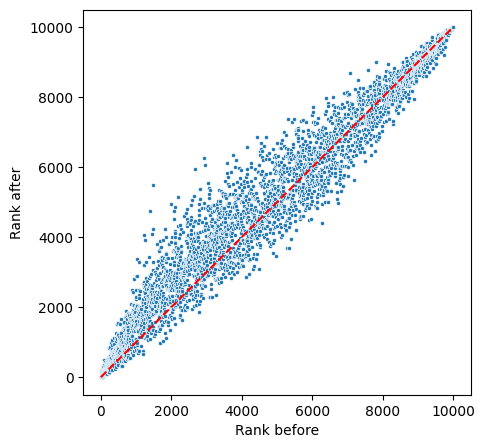

In [5]:
if STANDARDIZE or NORMALIZE:

    RANKS_TO_CONSIDER = 10000

    # Before standardisation
    grouped_ratings_before = detailed_ratings_before_rescaling \
        .groupby('beer_id')['rating'] \
        .agg(['mean', 'count']) \
        .sort_values(by='count', ascending=False) \
        .iloc[:RANKS_TO_CONSIDER] \
        .sort_values(by='mean', ascending=False)
    grouped_ratings_before['rank'] = np.arange(1, len(grouped_ratings_before) + 1)

    # After standardisation
    grouped_ratings_after = detailed_ratings \
        .groupby('beer_id')['rating'] \
        .agg(['mean', 'count']) \
        .sort_values(by='count', ascending=False) \
        .iloc[:RANKS_TO_CONSIDER] \
        .sort_values(by='mean', ascending=False)
    grouped_ratings_after['rank'] = np.arange(1, len(grouped_ratings_after) + 1)
    
    grouped_ratings = pd.merge(
        left=grouped_ratings_before,
        right=grouped_ratings_after,
        left_index=True,
        right_index=True,
        suffixes=('_before', '_after'),
    )

    grouped_ratings['count'] = grouped_ratings['count_before']
    grouped_ratings.drop(columns=['count_before', 'count_after'], inplace=True)

    plt.figure(figsize=(5, 5))
    sns.scatterplot(
        data=grouped_ratings,
        x='rank_before',
        y='rank_after',
        # size='count',
        marker='.',
        sizes=(10, 300),
    )
    plt.plot([0, RANKS_TO_CONSIDER], [0, RANKS_TO_CONSIDER], color='red', linestyle='--')
    plt.xlabel('Rank before')
    plt.ylabel('Rank after')

    delta_ranks = (grouped_ratings['rank_after'].values - grouped_ratings['rank_before'].values).mean()
    print(f"On average, the rank changed by {delta_ranks:.0f} positions (i.e. by {delta_ranks/RANKS_TO_CONSIDER:.1%}).")

### The naive model in action

In the following part, we will apply a very simple (almost naive) model to the data, which is a linear regression. First of all, we start by looking at the entire dataset.

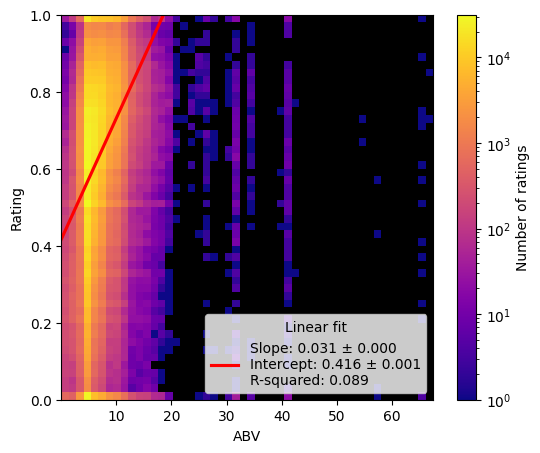

<Figure size 500x500 with 0 Axes>

In [6]:
# Initialize the figure
fig, ax = plt.subplots(figsize=(6, 5))

# Drawing the background histogram
plt.figure(figsize=(5, 5))
g = sns.histplot(
    data=detailed_ratings,
    x="abv",
    y="rating",
    bins=50,
    cmap="plasma",
    ax=ax,
    cbar=True,
    cbar_kws={'label': 'Number of ratings'},
    norm=LogNorm(), vmin=None, vmax=None, # Logarithmic color scale
)
g.set_facecolor('k')

# Drawing the regression line (and eventually the scatter)
regplot = sns.regplot(
    data=detailed_ratings,
    x="abv",
    y="rating",
    line_kws={'color':'r', 'alpha':1.0},
    scatter=False,
    ax=ax,
)

# Computing the regression and some statistics
x = detailed_ratings['abv'].values
y = detailed_ratings['rating'].values
result = scipy.stats.linregress(x=x, y=y)

# Finalizing the plot
ax.legend([get_fit_equation(result, 3)], loc='lower right', title='Linear fit')
ax.set(
    xlim=(x.min(), x.max()),
    ylim=(y.min(), y.max()),
    xlabel='ABV',
    ylabel='Rating',
)
plt.show()

Looking at the figure above, it seems clear that the naive model performs pretty poorly (because of the high $R^2$). Thus, we won't probably be able to explain the ratings only by looking at the ABV.

Though, let's still compare the naive model when considering only Americans and Europeans. For this, let's start by check if the dataset is balanced.

In [7]:
for continent_beer in ['Europe', 'America']:
    for continent_user in ['Europe', 'America']:
        print(
            f"Users from {continent_user} reviewing beers from {continent_beer}: " \
            + str(len(detailed_ratings.query("continent_user == @continent_user and continent_beer == @continent_beer")))
        )

Users from Europe reviewing beers from Europe: 556530
Users from America reviewing beers from Europe: 553184
Users from Europe reviewing beers from America: 33691
Users from America reviewing beers from America: 528319


For the purpose of what we are going to do, the dataset is balanced enough. But we could also perform a one-to-one matching.

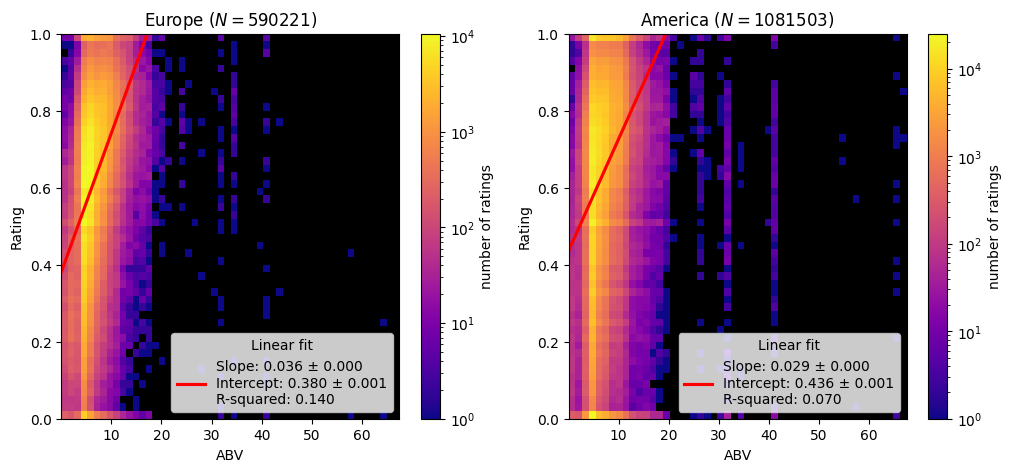

<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

In [8]:
fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(12, 5))

fit_results = []

for continent_index, continent in enumerate(['Europe', 'America']):

    df_ = detailed_ratings.query(f'continent_user == @continent')

    # Drawing the background histogram
    plt.figure(figsize=(5, 5))
    g = sns.histplot(
        data=df_,
        x="abv",
        y="rating",
        bins=50,
        cmap="plasma",
        ax=axes[continent_index],
        cbar=True,
        cbar_kws={'label': 'number of ratings'},
        norm=LogNorm(), vmin=None, vmax=None, # Logarithmic color scale
    )
    g.set_facecolor('k')

    # Drawing the regression line
    regplot = sns.regplot(
        data=df_,
        x="abv",
        y="rating",
        line_kws={'color':'r', 'alpha':1.0},
        scatter=False,
        ax=axes[continent_index],
    )

    # Computing the regression and some statistics
    x = df_['abv'].values
    y = df_['rating'].values
    result = scipy.stats.linregress(x=x, y=y)
    fit_results.append(result)

    # Finalizing the plot
    axes[continent_index].legend(
        [get_fit_equation(result, 3)],
        loc='lower right',
        title='Linear fit',
    )
    axes[continent_index].set(
        xlim=(detailed_ratings['abv'].min(), detailed_ratings['abv'].max()),
        ylim=(detailed_ratings['rating'].min(), detailed_ratings['rating'].max()),
        title=f'{continent} ($N={len(df_)}$)',
        xlabel='ABV',
        ylabel='Rating',
    )

plt.show()

To see if the two datasets do follow the same trend, we can look more into details at the models' coefficients Below we have plotted the values of each of them as well as their standard error, supposing it is normally distributed.

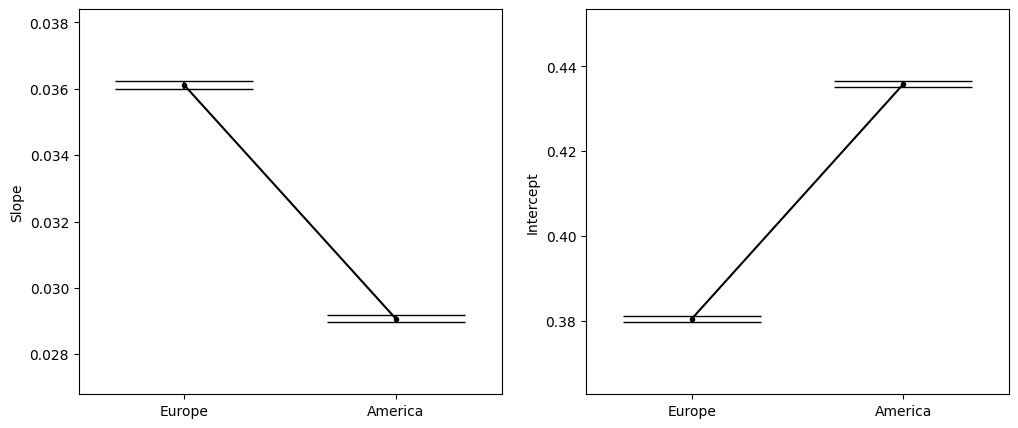

In [9]:
fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(12, 5))

axes[0].errorbar(
    x=[0, 1],
    y=[result.slope for result in fit_results],
    yerr=[result.stderr for result in fit_results],
    fmt='k.-',
    capsize=50,
)
axes[0].set(
    xticks=[0, 1],
    xticklabels=['Europe', 'America'],
    ylabel='Slope',
    xmargin=0.5, # Aesthetic
    ymargin=0.3, # Aesthetic
)

axes[1].errorbar(
    x=[0, 1],
    y=[result.intercept for result in fit_results],
    yerr=[result.intercept_stderr for result in fit_results],
    fmt='k.-',
    capsize=50,
)
axes[1].set(
    xticks=[0, 1],
    xticklabels=['Europe', 'America'],
    ylabel='Intercept',
    xmargin=0.5, # Aesthetic
    ymargin=0.3, # Aesthetic
)

plt.show()

By looking at the values for slopes and (altough less relevant) intercepts, we can see that their values do not overlap when considering the standard error. According to this, the two datasets do not follow the same trend. To be more precise, since the slope for europeans is significally higher, **this shows that Europeans seem to give higher ratings to beers with higher ABV**.

We can also draw the two linear regression results in the same plot to see how they differ.

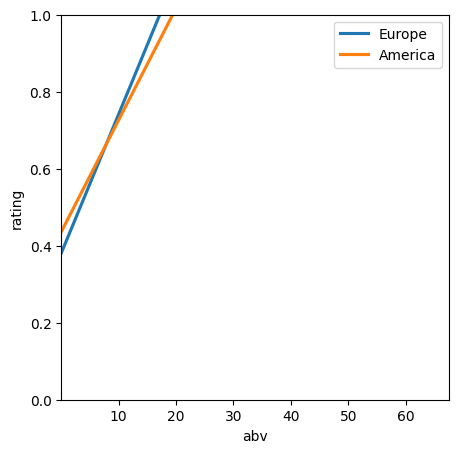

In [10]:
fig, ax = plt.subplots(figsize=(5, 5))

colors = ['tab:blue', 'tab:orange']

for continent_index, continent in enumerate(['Europe', 'America']):

    regplot = sns.regplot(
        data=detailed_ratings.query(f'continent_user == @continent'),
        x="abv",
        y="rating",
        line_kws={'color': colors[continent_index], 'alpha':1.0},
        scatter=False,
        ax=ax,
        label=continent,
    )
plt.xlim(detailed_ratings['abv'].min(), detailed_ratings['abv'].max())
plt.ylim(detailed_ratings['rating'].min(), detailed_ratings['rating'].max())
plt.legend()
plt.show()

### Performing one-to-one matching

All our previous results present a major issue: the dataset is not well balanced. Among these imbalances, we can cite:
* there are more american users' ratings than europeans';
* europeans tend to focus more on european beers, and more generally
* more european beers reviewed.

In the case where people prefer local beers, this would indeed introduce confounders. In order to mitigate that, we will perform a one-to-one matching. We will match one european rating to one americain when they have rated the same beer. This will ensure that we have, for each beer, as many american and european reviews. We will also only take a subset of beers, ensuring that we consider as many european and american ones.

When selecting beers, we will focus on the most rated ones. While this may at first glance introduce another biais where popular beers could imply that they are the best ones, we first show that there is no significant correlation between these two variables.

Text(0.5, 1.0, 'Correlation coefficient: $4.1 \\times 10^{-3}$')

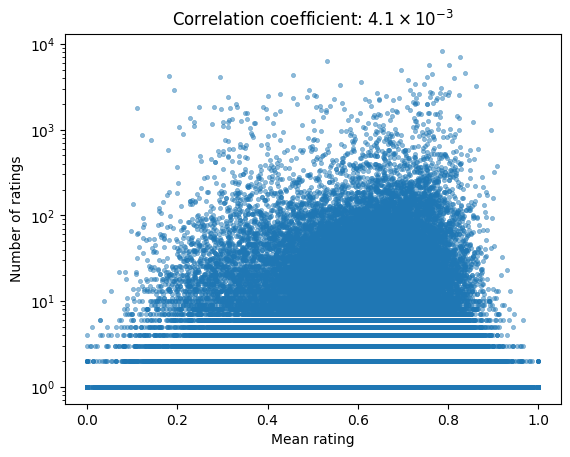

In [11]:
grouped_ratings = detailed_ratings \
    .groupby('beer_id')['rating'] \
    .agg(['mean', 'count']) \
    .sort_values(by='mean', ascending=False)

corr_coef = grouped_ratings.corr(method='pearson').iloc[0, 1]

sns.scatterplot(
    data=grouped_ratings,
    x='mean',
    y='count',
    marker='.',
    edgecolor=None,
    alpha=0.5,
)
plt.yscale('log')
plt.xlabel('Mean rating')
plt.ylabel('Number of ratings')
plt.title(f'Correlation coefficient: {num2scientific(corr_coef, decilams=1)}')

In [12]:
# Taking only the most rated beers, half of them being european, half of them
# being american. Note that this does not guarantee that we will end up with
# the exact number indicated.
BEERS_TO_KEEP = 1000
reviews_of_european_beers = detailed_ratings.query("continent_beer == 'Europe'")
reviews_of_american_beers = detailed_ratings.query("continent_beer == 'America'")
most_reviewed_european_beers = reviews_of_european_beers["beer_id"].value_counts().index[:BEERS_TO_KEEP // 2]
most_reviewed_american_beers = reviews_of_american_beers["beer_id"].value_counts().index[:BEERS_TO_KEEP // 2]
# most_reviewed_european_beers = reviews_of_european_beers.sample(BEERS_TO_KEEP // 2)["beer_id"].values
# most_reviewed_american_beers = reviews_of_american_beers.sample(BEERS_TO_KEEP // 2)["beer_id"].values
beer_ids = np.concatenate([most_reviewed_european_beers, most_reviewed_american_beers])

# Performing the one-to-one matching
matched_rows = []
for beer_id in tqdm(beer_ids, ascii=True):
    american_reviews = detailed_ratings.query("beer_id == @beer_id and continent_user == 'America'")
    european_reviews = detailed_ratings.query("beer_id == @beer_id and continent_user == 'Europe'")
    min_review_count = min(len(american_reviews), len(european_reviews))
    if min_review_count == 0:
        continue
    american_indices = american_reviews.sample(min_review_count).index
    european_indices = european_reviews.sample(min_review_count).index
    matched_rows += list(american_indices) + list(european_indices)

matched_df = detailed_ratings.loc[matched_rows]


100%|##########| 1000/1000 [01:43<00:00,  9.63it/s]


In the following, we show how well balanced the `matched_df` dataset is.

In [13]:
for continent_beer in ['Europe', 'America']:
    for continent_user in ['Europe', 'America']:
        print(
            f"Users from {continent_user} reviewing beers from {continent_beer}: " \
            + str(len(matched_df.query("continent_user == @continent_user and continent_beer == @continent_beer")))
        )

Users from Europe reviewing beers from Europe: 51123
Users from America reviewing beers from Europe: 51123
Users from Europe reviewing beers from America: 18274
Users from America reviewing beers from America: 18274


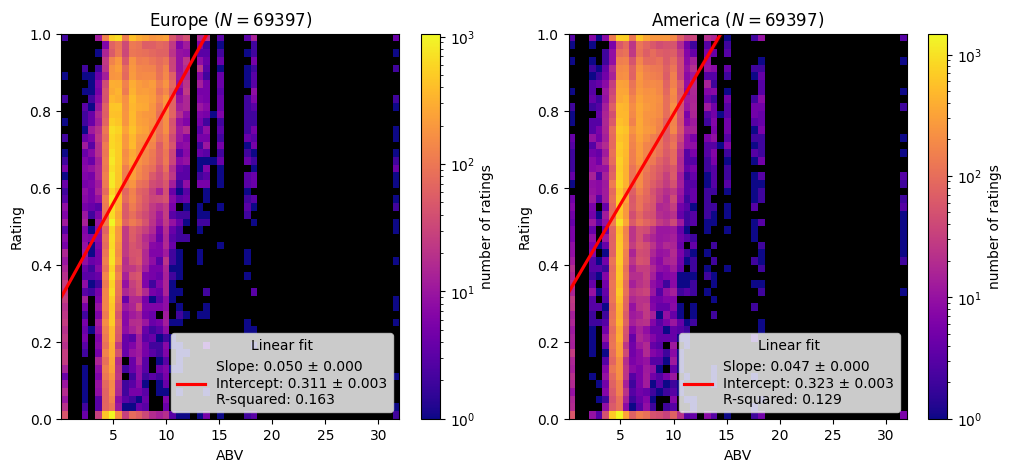

<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

In [14]:
fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(12, 5))

fit_results = []

for continent_index, continent in enumerate(['Europe', 'America']):

    df_ = matched_df.query(f'continent_user == @continent')

    # Drawing the background histogram
    plt.figure(figsize=(5, 5))
    g = sns.histplot(
        data=df_,
        x="abv",
        y="rating",
        bins=50,
        cmap="plasma",
        ax=axes[continent_index],
        cbar=True,
        cbar_kws={'label': 'number of ratings'},
        norm=LogNorm(), vmin=None, vmax=None, # Logarithmic color scale
    )
    g.set_facecolor('k')

    # Drawing the regression line
    regplot = sns.regplot(
        data=df_,
        x="abv",
        y="rating",
        line_kws={'color':'r', 'alpha':1.0},
        scatter=False,
        ax=axes[continent_index],
    )

    # Computing the regression and some statistics
    x = df_['abv'].values
    y = df_['rating'].values
    result = scipy.stats.linregress(x=x, y=y)
    fit_results.append(result)

    # Finalizing the plot
    axes[continent_index].legend([get_fit_equation(result, 3)], loc='lower right', title='Linear fit')
    axes[continent_index].set(
        xlim=(matched_df['abv'].min(), matched_df['abv'].max()),
        ylim=(matched_df['rating'].min(), matched_df['rating'].max()),
        title=f'{continent} ($N={len(df_)}$)',
        xlabel='ABV',
        ylabel='Rating',
    )
plt.show()

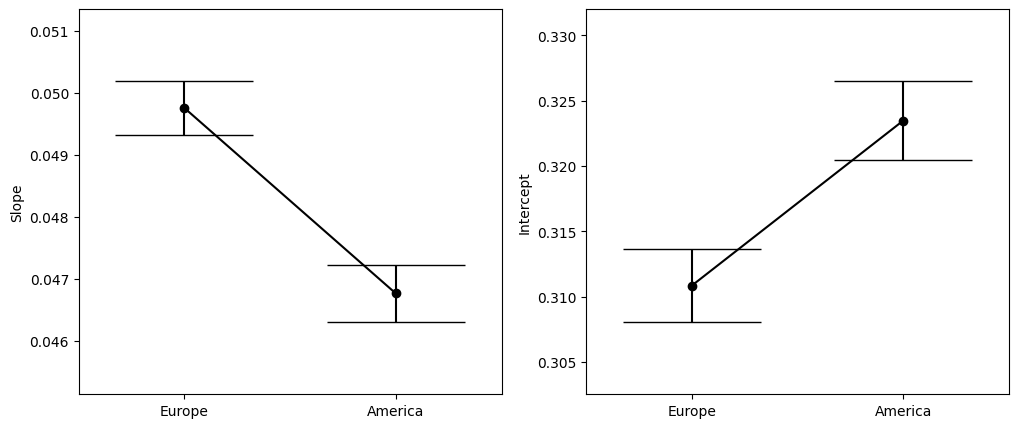

In [19]:
fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(12, 5))

axes[0].errorbar(
    x=[0, 1],
    y=[result.slope for result in fit_results],
    yerr=[result.stderr for result in fit_results],
    fmt='ko-',
    capsize=50,
)
axes[0].set(
    xticks=[0, 1],
    xticklabels=['Europe', 'America'],
    ylabel='Slope',
    xmargin=0.5, # Aesthetic
    ymargin=0.3, # Aesthetic
)

axes[1].errorbar(
    x=[0, 1],
    y=[result.intercept for result in fit_results],
    yerr=[result.intercept_stderr for result in fit_results],
    fmt='ko-',
    capsize=50,
)
axes[1].set(
    xticks=[0, 1],
    xticklabels=['Europe', 'America'],
    ylabel='Intercept',
    xmargin=0.5, # Aesthetic
    ymargin=0.3, # Aesthetic
)

plt.show()

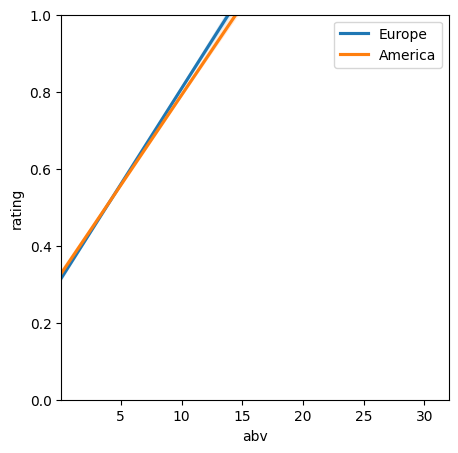

In [16]:
fig, ax = plt.subplots(figsize=(5, 5))

colors = ['tab:blue', 'tab:orange']

for continent_index, continent in enumerate(['Europe', 'America']):

    regplot = sns.regplot(
        data=matched_df.query(f'continent_user == @continent'),
        x="abv",
        y="rating",
        scatter=False,
        x_jitter=0.1,
        y_jitter=0.1,
        marker='.',
        scatter_kws={'color':'k', 'alpha':0.1},
        line_kws={'color': colors[continent_index], 'alpha':1.0},
        ax=ax,
        label=continent,
    )
plt.xlim(matched_df['abv'].min(), matched_df['abv'].max())
plt.ylim(matched_df['rating'].min(), matched_df['rating'].max())
plt.legend()
plt.show()

According to this new result, we may change a bit our initial conclusion. While Europeans still seem to give higher ratings to beers with higher ABV (the slope being still steeper), the two linear regressions are now much closer in the 10% ABV range. Thus, it is mostly the beers with high ABV that distinguish the two datasets. In other words, beers with low to medium ABV are rated similarly by both Europeans and Americans.

### Using micro-averages

To make the upper fact more clear, we may group ratings (e.g. by groups of 10% ABV), and compute micro-averages.

C:\Users\julie\AppData\Local\Temp\ipykernel_25036\2190675483.py:34: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45)
C:\Users\julie\AppData\Local\Temp\ipykernel_25036\2190675483.py:37: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_yticklabels(ax2.get_yticklabels(), color='red')


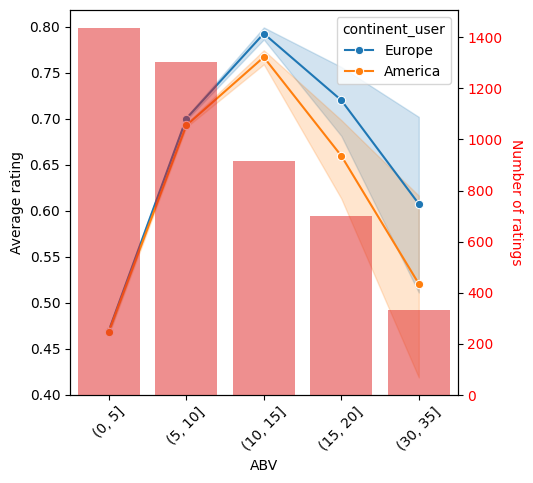

In [17]:
# Computing groups
grouped_ratings = matched_df.copy()
grouped_ratings['abv_group'] = pd.cut(grouped_ratings['abv'], bins=np.arange(0, 70, 5))
grouped_ratings.dropna(subset=['abv_group'], inplace=True)
grouped_ratings.sort_values(by='abv_group', inplace=True)
grouped_ratings['abv_group'] = grouped_ratings['abv_group'].astype(str)

# Drawing the micro-averages
fig, ax1 = plt.subplots(figsize=(5, 5))
ax2 = ax1.twinx()

sns.lineplot(
    data=grouped_ratings,
    x='abv_group',
    y='rating',
    estimator="mean",
    hue='continent_user',
    hue_order=['Europe', 'America'],
    errorbar=('ci', 95),
    marker='o',
    # dodge=0.1, # Aesthetic 
    ax=ax1,
    # capsize=0.2,
)
sns.barplot(
    data=grouped_ratings,
    x='abv_group',
    y='nbr_ratings_beer',
    color='red',
    ax=ax2,
    alpha=0.5,
    errorbar=None,
)
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45)
ax1.set_xlabel('ABV')
ax1.set_ylabel('Average rating')
ax2.set_yticklabels(ax2.get_yticklabels(), color='red')
ax2.set_ylabel('Number of ratings', rotation=270, labelpad=15, color='red')
plt.show()

Looking more in details at the figure above, the before mentioned trend can in fact be explained as follows: Most of the beers reviewed have a low ABV (equal or below 10%). In this range, the ratings are very similar for both Europeans and Americans. This may explain the fact that the two linear regressions were very close in this range. In the medium to mid-high range (about 10% to 40%), Europeans tend to give better results, with sometimes a very significant difference. Finally, in the high range (above 40%), the difference is not significant anymore, and Americans even tend to give better ratings to very high ABV beers. Altough, this last result is not very significant, since there are only a few beers in this range and thus a very high variance.

---

Looking more in details at the figure above, the before mentioned trend can be explained. Most of the beers reviewed have a pretty low ABV. At around 5% ABV, the ratings are very similar for both Europeans and Americans, which may explain the fact that the two linear regressions were very close in this range. For larger values though, Europeans tend to give higher ratings overall.